In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
import numpy as np

In [2]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [46]:
police_shooting = pd.read_csv('US Police shootings in from 2015-22_Clean.csv')
available_states = police_shooting['state'].unique()
available_races = police_shooting['race'].unique()
available_arms = police_shooting['armed'].unique()
last_available_date = datetime.datetime.strptime(police_shooting.sort_values(by=['date'], ascending=False).iloc[0, :]['date'], '%Y-%m-%d')

In [20]:
data_trained = police_shooting.groupby(['date', 'armed']).size().reset_index()
data_trained = data_trained.rename({0: 'y'}, axis=1)

In [21]:
for i in range(1, 6):
    data_trained['target_lag_{}'.format(i)] = data_trained.y.shift(i)
data_trained = data_trained.iloc[5:, :].reset_index(drop=True)

In [22]:
data_trained['armed'] = data_trained['armed'].astype("string")
data_trained['date'] = pd.to_datetime(data_trained['date'])

In [23]:
data_trained.insert(1, "month", data_trained['date'].dt.month)
data_trained.insert(2, "day_of_year", data_trained['date'].dt.day_of_year)

In [24]:
data_trained.insert(3, "month_sin", sin_transformer(12).fit_transform(data_trained["month"]))
data_trained.insert(4, "month_cos", cos_transformer(12).fit_transform(data_trained["month"]))

data_trained.insert(5, "day_sin", sin_transformer(365).fit_transform(data_trained["day_of_year"]))
data_trained.insert(6, "day_cos", cos_transformer(365).fit_transform(data_trained["day_of_year"]))

In [25]:
data_trained.drop(columns=['date', 'month', 'day_of_year'], inplace=True)

In [26]:
data_trained = pd.get_dummies(data_trained, columns=['armed'], prefix='', prefix_sep='').iloc[:, :-1]

In [27]:
dummy_armed_columns = list(data_trained.columns)[list(data_trained.columns).index('target_lag_5') + 1:]

In [28]:
def x_scaler(df):
	scaler = MinMaxScaler(feature_range=(0, 1)).fit(df)

	data_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
	return scaler, data_scaled

In [29]:
data_trained_scaler, data_trained_scaled = x_scaler(data_trained)

In [30]:
X = data_trained_scaled.loc[:, data_trained_scaled.columns != 'y']
y = data_trained_scaled['y']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

## Training

In [32]:
data_gen_train = TimeseriesGenerator(X_train.to_numpy(), y_train.to_numpy(), length=7, batch_size=1)
data_gen_test = TimeseriesGenerator(X_test.to_numpy(), y_test.to_numpy(), length=7, batch_size=1)

In [33]:
simodel = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(7, 22)),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
simodel.compile(loss='mean_squared_error', optimizer='adam')
simodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            49200     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 129,701
Trainable params: 129,701
Non-trainable params: 0
_________________________________________________________________


In [34]:
si_mode_history = simodel.fit(data_gen_train, epochs=15, batch_size=4, validation_data=data_gen_test, callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Epoch 1/15
3553/3553 [==============================] - 18s 4ms/step - loss: 0.0239 - val_loss: 0.0234
Epoch 2/15
3553/3553 [==============================] - 14s 4ms/step - loss: 0.0236 - val_loss: 0.0234
Epoch 3/15
3553/3553 [==============================] - 14s 4ms/step - loss: 0.0236 - val_loss: 0.0234
Epoch 4/15
3553/3553 [==============================] - 16s 5ms/step - loss: 0.0235 - val_loss: 0.0234
Epoch 5/15
3553/3553 [==============================] - 15s 4ms/step - loss: 0.0235 - val_loss: 0.0234
Epoch 6/15
3553/3553 [==============================] - 14s 4ms/step - loss: 0.0235 - val_loss: 0.0234
Epoch 7/15
3553/3553 [==============================] - 14s 4ms/step - loss: 0.0234 - val_loss: 0.0234
Epoch 8/15
3553/3553 [==============================] - 14s 4ms/step - loss: 0.0232 - val_loss: 0.0234
Epoch 9/15
3553/3553 [==============================] - 14s 4ms/step - loss: 0.0231 - val_loss: 0.0235
Epoch 10/15
3553/3553 [==============================] - 14s 4ms/step - l

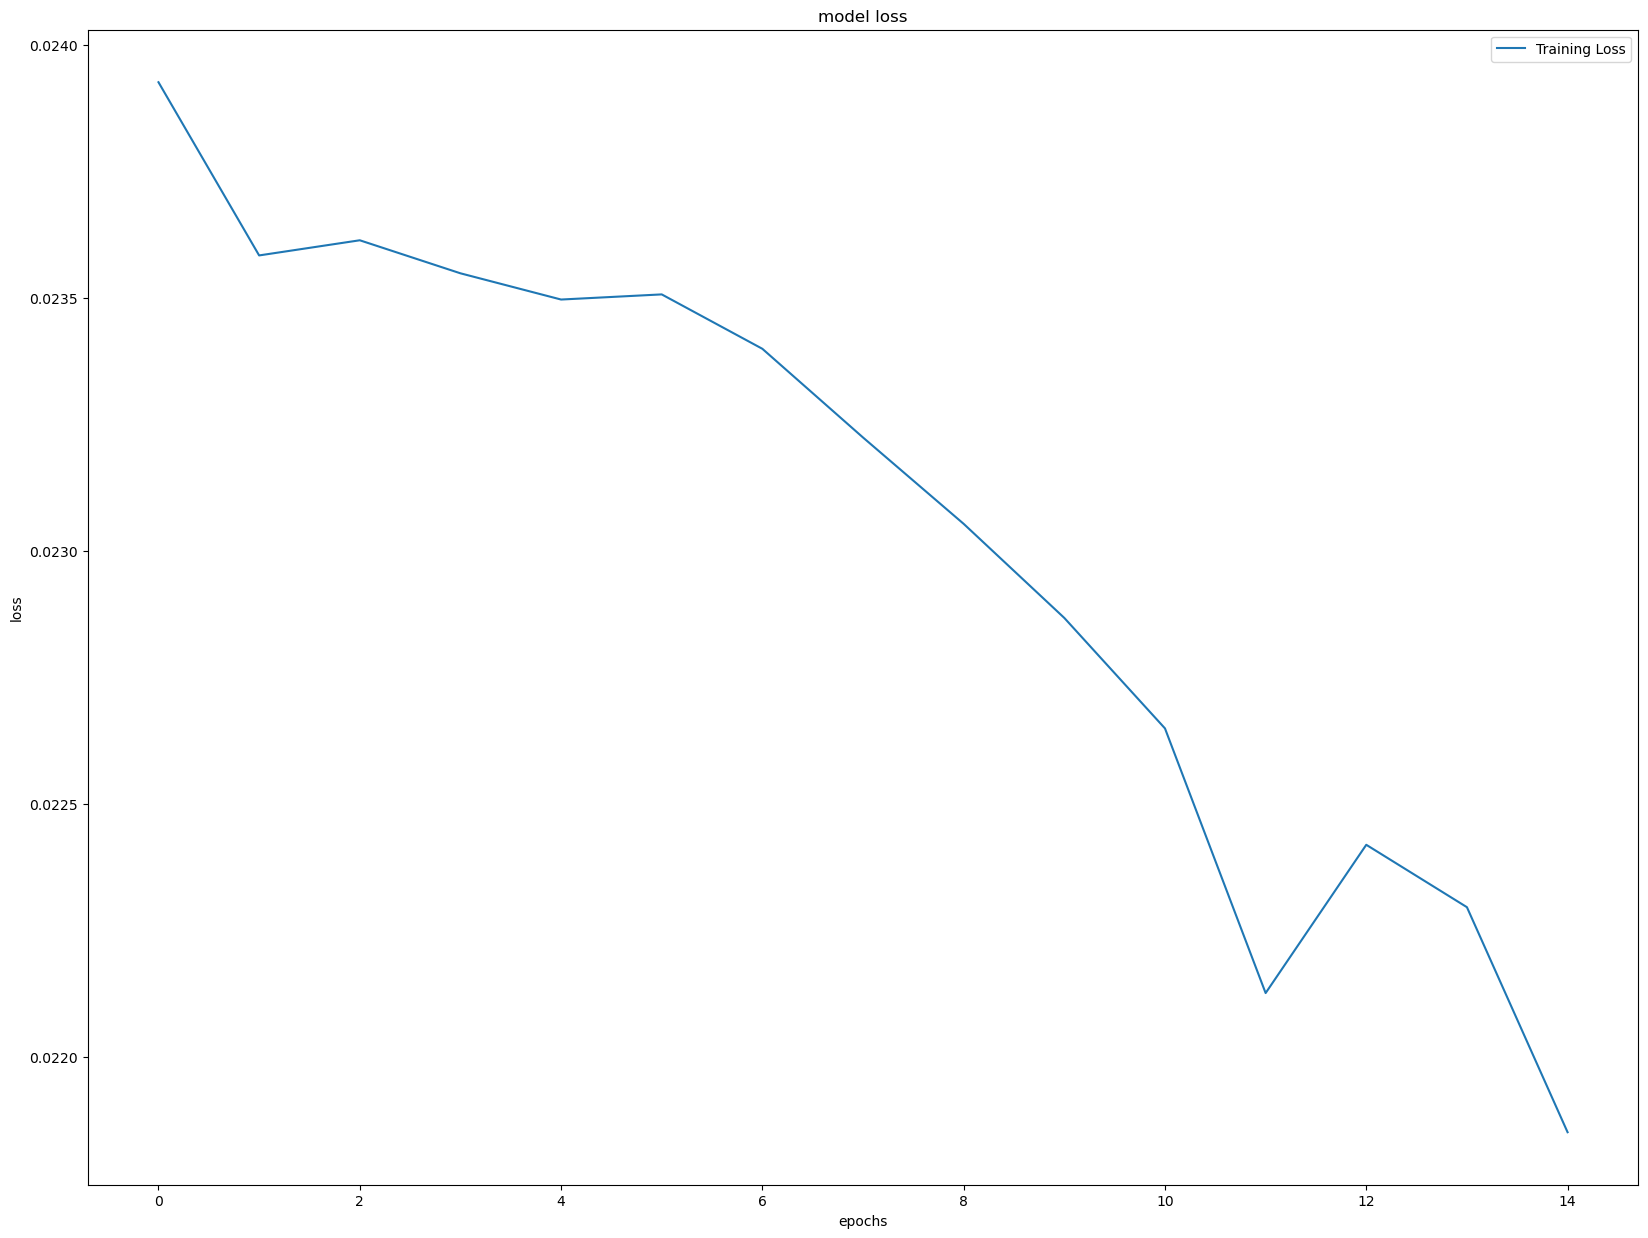

In [35]:
plt.figure(figsize=(20,15))
plt.plot(si_mode_history.history['loss'], label='Training Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [64]:
prediction_result = simodel.predict(data_gen_test)

1519/1519 [==============================] - 2s 2ms/step


In [65]:
test = []
for i in range(len(data_gen_test)):
	x, y = data_gen_test[i]
	test.append(y[0])

In [66]:
print('Test Mean Absolute Error:', mean_squared_error(test, prediction_result))

Test Mean Absolute Error: 0.02502893071159172


## Predict

In [67]:
last_available_date

datetime.datetime(2022, 9, 7, 0, 0)

In [68]:
last_available_date.month, last_available_date.timetuple().tm_yday

(9, 250)

In [96]:
def predict(arm_type: str):
    prection_df = pd.DataFrame([], columns=['date', 'armed', 'shootingCount'])
    armed_dummy = [int(arm_type == name) for name in dummy_armed_columns]
    input_rows = X.iloc[-9:-1, :].reset_index(drop=True)
    input_date = last_available_date

    for index in range(1, 350):
        lag_data = input_rows.iloc[-8:-1, :]
        
        prediction_ongoing = simodel.predict(lag_data.to_numpy().reshape(-1, 7, 22))
        input_date = input_date + datetime.timedelta(days=1)
        
        month_sin = sin_transformer(12).fit_transform(input_date.month)
        month_cos = cos_transformer(12).fit_transform(input_date.month)
        
        day_sin = sin_transformer(365).fit_transform(input_date.timetuple().tm_yday)
        day_cos = cos_transformer(365).fit_transform(input_date.timetuple().tm_yday)
                
        next_row = [month_sin, month_cos, day_sin, day_cos, prediction_ongoing[0][0], *lag_data[['target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_4']].iloc[-1:, :].to_numpy()[0], *armed_dummy]
        
        input_rows.loc[len(input_rows)] = next_row

        prection_df.loc[len(prection_df)] = [input_date, arm_type, prediction_ongoing[0][0]]
    return prection_df

In [97]:
final_prediction_armed = pd.DataFrame([], columns=['date', 'armed', 'shootingCount'])
for arm_type in dummy_armed_columns:
    final_prediction_armed = pd.concat([final_prediction_armed, predict(arm_type)], axis=0, ignore_index=True)

1/1 [==============================] - 0s 25ms/step


In [98]:
final_prediction_armed.to_csv('armed-prediction.csv', index=False)